In [1]:
import pandas as pd
import numpy as np
import re, ast, warnings
import matplotlib.pyplot as plt

from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from scipy.stats import chi2_contingency

D:\jupyter\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8,4)

In [3]:
DATA_PATH =  "C:\\Users\\87738\\Desktop\\ERP\\math_anxiety_processed.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)

In [4]:
if "created_at" in df.columns:
    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

def parse_listish(x):
    if isinstance(x, list):
        return [str(t).lower() for t in x]
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            if isinstance(val, list):
                return [str(t).lower() for t in val]
        except Exception:
            pass
        return re.findall(r"[a-zA-Z']+", x.lower())
    return []
if "processed_text" in df.columns and df["processed_text"].notna().any():
    doc_source = df["processed_text"].fillna("").astype(str).tolist()
    docs = [re.findall(r"[a-zA-Z']+", s.lower()) for s in doc_source]
elif "lemmas" in df.columns and df["lemmas"].notna().any():
    docs = df["lemmas"].fillna("").map(parse_listish).tolist()
elif "tokens" in df.columns and df["tokens"].notna().any():
    docs = df["tokens"].fillna("").map(parse_listish).tolist()
elif "clean_text" in df.columns and df["clean_text"].notna().any():
    doc_source = df["clean_text"].fillna("").astype(str).tolist()
    docs = [re.findall(r"[a-zA-Z']+", s.lower()) for s in doc_source]
else:
    doc_source = df["text"].fillna("").astype(str).tolist()
    docs = [re.findall(r"[a-zA-Z']+", s.lower()) for s in doc_source]

In [5]:
custom_stop = set(ENGLISH_STOP_WORDS) | {
    "math","exam","exams","test","tests", 
    "im","ive","dont","cant","didnt","doesnt","isnt","wasnt","youre","theyre",
    "http","https","co","amp"
}
def clean_tokens(tok_list):
    return [w for w in tok_list if len(w) > 2 and w not in custom_stop]

docs = [clean_tokens(toks) for toks in docs]

mask = [len(t)>0 for t in docs]
df = df.loc[mask].reset_index(drop=True)
docs = [t for t in docs if len(t)>0]

print(f"Number of documents available for LDA: {len(docs)}")

Number of documents available for LDA: 2069


In [6]:
id2word = corpora.Dictionary(docs)
id2word.filter_extremes(no_below=10, no_above=0.5, keep_n=50000)
corpus = [id2word.doc2bow(doc) for doc in docs]
nonempty = [len(b)>0 for b in corpus]
df = df.loc[nonempty].reset_index(drop=True)
docs = [d for d,b in zip(docs, nonempty) if b]
corpus = [b for b in corpus if len(b)>0]

print(f"Number of documents after filtering: {len(corpus)}, Dictionary size: {len(id2word)}")

Number of documents after filtering: 2069, Dictionary size: 74


In [7]:
cand_topics = list(range(5, 11))  
results = []

for k in cand_topics:
    lda = models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=k,
        random_state=42,
        chunksize=2000,
        passes=10,
        alpha='symmetric',
        eta='auto',
        eval_every=None
    )
    cm = CoherenceModel(model=lda, texts=docs, dictionary=id2word, coherence='c_v')
    coh = cm.get_coherence()
    log_perp = lda.log_perplexity(corpus)
    results.append((k, coh, log_perp, lda))
    print(f"k={k} | coherence={coh:.3f} | log_perplexity={log_perp:.3f}")
best_k, best_coh, best_logperp, lda_model = max(results, key=lambda x: x[1])
print(f"\nSelect the optimal number of themes: k={best_k}，coherence={best_coh:.3f}，log_perplexity={best_logperp:.3f}")


k=5 | coherence=0.603 | log_perplexity=-3.608
k=6 | coherence=0.611 | log_perplexity=-3.512
k=7 | coherence=0.617 | log_perplexity=-3.462
k=8 | coherence=0.612 | log_perplexity=-3.397
k=9 | coherence=0.625 | log_perplexity=-3.331
k=10 | coherence=0.612 | log_perplexity=-3.300

Select the optimal number of themes: k=9，coherence=0.625，log_perplexity=-3.331


In [8]:
topn = 15
topic_rows = []
for t in range(best_k):
    terms = lda_model.show_topic(t, topn=topn)
    topic_rows.append({
        "topic_id": t,
        "top_words": ", ".join([w for w,_ in terms])
    })
topics_df = pd.DataFrame(topic_rows)
topics_df

,topic_id,top_words
0,0,"trigonometri, hard, whi, club, today, meet, lo..."
1,1,"class, lost, complet, statist, progress, proud..."
2,2,"feel, algebra, learn, befor, stress, confid, r..."
3,3,"calculu, thi, hate, homework, headach, feel, g..."
4,4,"equat, handl, anymor, can't, algebra, problem,..."
5,5,"statist, assign, exercis, practic, hard, whi, ..."
6,6,"solv, problem, workbook, everi, panic, set, te..."
7,7,"frustrat, fail, brain, problem, freez, best, p..."
8,8,"class, studi, tomorrow', schedul, actual, fun,..."


,topic_id,n_docs,share
0,0,180,0.086999
1,1,198,0.095698
2,2,401,0.193813
3,3,286,0.138231
4,4,174,0.084099
5,5,115,0.055582
6,6,172,0.083132
7,7,264,0.127598
8,8,279,0.134848


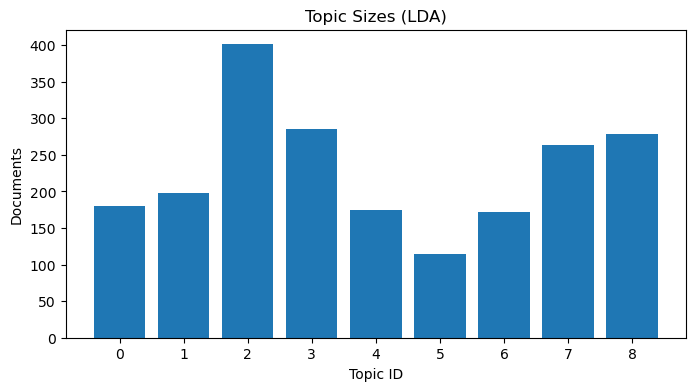

In [10]:
def dominant_topic(bow):
    dist = lda_model.get_document_topics(bow, minimum_probability=0)
    t, p = max(dist, key=lambda x: x[1])
    return t, p

assign = [dominant_topic(b) for b in corpus]
df["topic_id"] = [a[0] for a in assign]
df["topic_prob"] = [a[1] for a in assign]
topic_sizes = df["topic_id"].value_counts().sort_index()
topic_share = (topic_sizes / topic_sizes.sum()).rename("share")
display(pd.DataFrame({"n_docs": topic_sizes, "share": topic_share}).reset_index().rename(columns={"index":"topic_id"}))
plt.bar(topic_sizes.index.astype(str), topic_sizes.values)
plt.xlabel("Topic ID")
plt.ylabel("Documents")
plt.title("Topic Sizes (LDA)")
plt.show()

Emotion × Theme Cross-tabulation Table：


is_negative,0,1
topic_id,,
0,73,107
1,89,109
2,196,205
3,95,191
4,66,108
5,115,0
6,77,95
7,38,226
8,279,0



Chi-square: chi2=580.710, dof=8, p-value=0.0000


,topic_id,negative_rate
7,7,0.856061
3,3,0.667832
4,4,0.620690
0,0,0.594444
6,6,0.552326
1,1,0.550505
2,2,0.511222
5,5,0.000000
8,8,0.000000


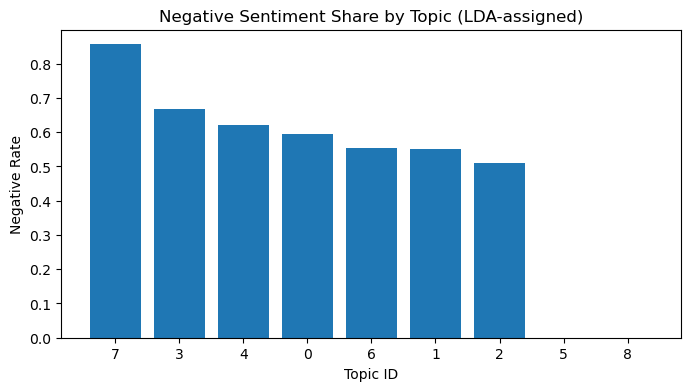

In [11]:
def norm_sent(s):
    s = str(s).strip().lower()
    if s.startswith("neg"):
        return "negative"
    if s.startswith("pos"):
        return "positive"
    return "neutral"

if "sentiment" in df.columns:
    df["sent_label"] = df["sentiment"].map(norm_sent)
else:
    df["sent_label"] = "neutral"

df["is_negative"] = (df["sent_label"]=="negative").astype(int)

ct = pd.crosstab(df["topic_id"], df["is_negative"])
chi2, pval, dof, expected = chi2_contingency(ct)
print("Emotion × Theme Cross-tabulation Table：")
display(ct)
print(f"\nChi-square: chi2={chi2:.3f}, dof={dof}, p-value={pval:.4f}")


neg_rate = (
    df.groupby("topic_id")["is_negative"]
      .mean()
      .reset_index(name="negative_rate")
      .sort_values("negative_rate", ascending=False)
)
display(neg_rate)

plt.bar(neg_rate["topic_id"].astype(str), neg_rate["negative_rate"])
plt.xlabel("Topic ID")
plt.ylabel("Negative Rate")
plt.title("Negative Sentiment Share by Topic (LDA-assigned)")
plt.show()



In [15]:
doc_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)

assign = []
for row in doc_topics:
    # row = [(topic_id, prob), ...] for this document
    top_topic = max(row, key=lambda x: x[1])  # select dominant topic
    assign.append(top_topic)  # (topic_id, probability)

# Add dominant topic info to df
df["topic_id"] = [a[0] for a in assign]
df["topic_weight"] = [a[1] for a in assign]

# Keep only useful columns for merging in Chapter 6
cols_to_keep = ["id", "created_at", "topic_id", "topic_weight"]
df_assign = df[cols_to_keep].copy()

# Save as new file
df_assign.to_csv("lda_doc_topic_assignments.csv", index=False)

print("Exported lda_doc_topic_assignments.csv with columns:", df_assign.columns.tolist())
print("Rows:", len(df_assign))
print(df_assign.head())

Exported lda_doc_topic_assignments.csv with columns: ['id', 'created_at', 'topic_id', 'topic_weight']
Rows: 2069
        id          created_at  topic_id  topic_weight
0  2000000 2024-04-25 16:22:00         7      0.777753
1  2000001 2023-02-23 23:26:00         2      0.822213
2  2000002 2024-02-16 05:31:00         7      0.822201
3  2000003 2021-05-01 11:19:00         7      0.703704
4  2000004 2021-09-07 01:51:00         2      0.703698


'C:\\Users\\87738'